In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size)
        Qlogits = tf.layers.dense(inputs=states_logits, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    ################################################ s', r = env(s, a)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=states.dtype)
    e_next_states_logits, eQlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size,
                                         action_size=action_size, state_size=state_size)
    ################################################ a = act(s)
    ################################################ s', r = env(s, a)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    a_next_states_logits, aQlogits = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size, reuse=True)
    ###############################################
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                         axis=1))
    eloss += -tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                   labels=next_states_labels), 
                                           axis=1))
    aloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                          axis=1))
    #################################################### 
    eQlogits = tf.reshape(eQlogits, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQlogits, labels=rates))
    ################################################ a = act(s)
    aQlogits = tf.reshape(aQlogits, shape=[-1])
    eloss += tf.reduce_mean(tf.square(eQlogits - aQlogits))
    aloss += tf.reduce_mean(aQlogits)
    return actions_logits, aloss, eloss

In [7]:
def model_opt(a_loss, e_loss, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
    return a_opt, e_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, next_states=self.next_states, dones=self.dones, 
            rates=self.rates)
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt = model_opt(a_loss=self.a_loss, e_loss=self.e_loss,
                                           a_learning_rate=a_learning_rate,
                                           e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
rate = -1
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset
        rate = -1 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [15]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch = [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 aloss:2.7910 eloss:0.7850 exploreP:0.9985
Episode:1 meanR:16.5000 R:18.0000 rate:0.0360 aloss:2.7633 eloss:0.7653 exploreP:0.9967
Episode:2 meanR:16.6667 R:17.0000 rate:0.0340 aloss:2.7771 eloss:0.7647 exploreP:0.9951
Episode:3 meanR:15.0000 R:10.0000 rate:0.0200 aloss:2.7135 eloss:0.7524 exploreP:0.9941
Episode:4 meanR:17.6000 R:28.0000 rate:0.0560 aloss:2.7646 eloss:0.7501 exploreP:0.9913
Episode:5 meanR:21.6667 R:42.0000 rate:0.0840 aloss:2.7162 eloss:0.7299 exploreP:0.9872
Episode:6 meanR:20.4286 R:13.0000 rate:0.0260 aloss:2.6461 eloss:0.7000 exploreP:0.9859
Episode:7 meanR:20.1250 R:18.0000 rate:0.0360 aloss:2.6867 eloss:0.7151 exploreP:0.9842
Episode:8 meanR:26.0000 R:73.0000 rate:0.1460 aloss:2.6568 eloss:0.7034 exploreP:0.9771
Episode:9 meanR:26.8000 R:34.0000 rate:0.0680 aloss:2.6088 eloss:0.6880 exploreP:0.9738
Episode:10 meanR:25.6364 R:14.0000 rate:0.0280 aloss:2.6020 eloss:0.6775 exploreP:0.9725
Episode:11 meanR:24.4167 R:11.0

Episode:93 meanR:23.1277 R:39.0000 rate:0.0780 aloss:1.3532 eloss:0.3040 exploreP:0.8066
Episode:94 meanR:23.0421 R:15.0000 rate:0.0300 aloss:1.3555 eloss:0.2916 exploreP:0.8054
Episode:95 meanR:22.9271 R:12.0000 rate:0.0240 aloss:1.3803 eloss:0.3011 exploreP:0.8044
Episode:96 meanR:23.1340 R:43.0000 rate:0.0860 aloss:1.4186 eloss:0.2149 exploreP:0.8010
Episode:97 meanR:23.0918 R:19.0000 rate:0.0380 aloss:1.4399 eloss:0.2291 exploreP:0.7995
Episode:98 meanR:23.0505 R:19.0000 rate:0.0380 aloss:1.4501 eloss:0.1844 exploreP:0.7980
Episode:99 meanR:22.9600 R:14.0000 rate:0.0280 aloss:1.4877 eloss:0.2068 exploreP:0.7969
Episode:100 meanR:22.9300 R:12.0000 rate:0.0240 aloss:1.4889 eloss:0.2295 exploreP:0.7960
Episode:101 meanR:22.8600 R:11.0000 rate:0.0220 aloss:1.5102 eloss:0.1487 exploreP:0.7951
Episode:102 meanR:22.7800 R:9.0000 rate:0.0180 aloss:1.4931 eloss:0.1740 exploreP:0.7944
Episode:103 meanR:22.8100 R:13.0000 rate:0.0260 aloss:1.5243 eloss:0.0980 exploreP:0.7934
Episode:104 meanR:

Episode:185 meanR:20.1000 R:21.0000 rate:0.0420 aloss:1.3268 eloss:0.3791 exploreP:0.6724
Episode:186 meanR:20.2400 R:30.0000 rate:0.0600 aloss:1.3261 eloss:0.3453 exploreP:0.6704
Episode:187 meanR:20.2500 R:24.0000 rate:0.0480 aloss:1.3379 eloss:0.3626 exploreP:0.6688
Episode:188 meanR:20.2700 R:36.0000 rate:0.0720 aloss:1.3083 eloss:0.3716 exploreP:0.6664
Episode:189 meanR:20.2700 R:17.0000 rate:0.0340 aloss:1.3124 eloss:0.3963 exploreP:0.6653
Episode:190 meanR:20.3500 R:17.0000 rate:0.0340 aloss:1.2868 eloss:0.3654 exploreP:0.6642
Episode:191 meanR:20.3600 R:12.0000 rate:0.0240 aloss:1.2916 eloss:0.3616 exploreP:0.6634
Episode:192 meanR:20.3300 R:13.0000 rate:0.0260 aloss:1.3001 eloss:0.3937 exploreP:0.6626
Episode:193 meanR:20.0500 R:11.0000 rate:0.0220 aloss:1.3010 eloss:0.3963 exploreP:0.6618
Episode:194 meanR:20.0400 R:14.0000 rate:0.0280 aloss:1.2777 eloss:0.3825 exploreP:0.6609
Episode:195 meanR:20.0200 R:10.0000 rate:0.0200 aloss:1.2679 eloss:0.3629 exploreP:0.6603
Episode:19

Episode:277 meanR:17.1700 R:12.0000 rate:0.0240 aloss:1.3014 eloss:0.3088 exploreP:0.5804
Episode:278 meanR:17.0400 R:12.0000 rate:0.0240 aloss:1.3622 eloss:0.3365 exploreP:0.5798
Episode:279 meanR:16.6900 R:10.0000 rate:0.0200 aloss:1.4050 eloss:0.3367 exploreP:0.5792
Episode:280 meanR:16.6400 R:18.0000 rate:0.0360 aloss:1.3579 eloss:0.3458 exploreP:0.5782
Episode:281 meanR:16.4800 R:10.0000 rate:0.0200 aloss:1.3328 eloss:0.3435 exploreP:0.5776
Episode:282 meanR:16.3600 R:14.0000 rate:0.0280 aloss:1.3924 eloss:0.3309 exploreP:0.5768
Episode:283 meanR:16.2700 R:10.0000 rate:0.0200 aloss:1.3761 eloss:0.3276 exploreP:0.5762
Episode:284 meanR:15.9800 R:9.0000 rate:0.0180 aloss:1.3737 eloss:0.3262 exploreP:0.5757
Episode:285 meanR:15.9200 R:15.0000 rate:0.0300 aloss:1.3519 eloss:0.3508 exploreP:0.5749
Episode:286 meanR:15.7300 R:11.0000 rate:0.0220 aloss:1.2988 eloss:0.3379 exploreP:0.5743
Episode:287 meanR:15.5800 R:9.0000 rate:0.0180 aloss:1.3528 eloss:0.3478 exploreP:0.5737
Episode:288 

Episode:369 meanR:12.2000 R:15.0000 rate:0.0300 aloss:1.4878 eloss:0.2954 exploreP:0.5194
Episode:370 meanR:12.2600 R:15.0000 rate:0.0300 aloss:1.5005 eloss:0.2684 exploreP:0.5187
Episode:371 meanR:12.2500 R:10.0000 rate:0.0200 aloss:1.4554 eloss:0.2956 exploreP:0.5182
Episode:372 meanR:12.2500 R:11.0000 rate:0.0220 aloss:1.6154 eloss:0.2665 exploreP:0.5176
Episode:373 meanR:12.2800 R:11.0000 rate:0.0220 aloss:1.4725 eloss:0.2654 exploreP:0.5170
Episode:374 meanR:12.2800 R:12.0000 rate:0.0240 aloss:1.5772 eloss:0.2443 exploreP:0.5164
Episode:375 meanR:12.2400 R:13.0000 rate:0.0260 aloss:1.5546 eloss:0.3154 exploreP:0.5158
Episode:376 meanR:12.2500 R:10.0000 rate:0.0200 aloss:1.5061 eloss:0.2667 exploreP:0.5153
Episode:377 meanR:12.2500 R:12.0000 rate:0.0240 aloss:1.5205 eloss:0.2814 exploreP:0.5147
Episode:378 meanR:12.2200 R:9.0000 rate:0.0180 aloss:1.5668 eloss:0.2669 exploreP:0.5142
Episode:379 meanR:12.2400 R:12.0000 rate:0.0240 aloss:1.4846 eloss:0.2622 exploreP:0.5136
Episode:380

Episode:461 meanR:11.7600 R:10.0000 rate:0.0200 aloss:1.9374 eloss:0.2381 exploreP:0.4670
Episode:462 meanR:11.7700 R:10.0000 rate:0.0200 aloss:2.0106 eloss:0.1748 exploreP:0.4665
Episode:463 meanR:11.7400 R:9.0000 rate:0.0180 aloss:1.9877 eloss:0.2060 exploreP:0.4661
Episode:464 meanR:11.7900 R:16.0000 rate:0.0320 aloss:1.9590 eloss:0.2014 exploreP:0.4654
Episode:465 meanR:11.7500 R:10.0000 rate:0.0200 aloss:1.9723 eloss:0.2135 exploreP:0.4649
Episode:466 meanR:11.8000 R:14.0000 rate:0.0280 aloss:2.0988 eloss:0.2154 exploreP:0.4643
Episode:467 meanR:11.8300 R:13.0000 rate:0.0260 aloss:2.0644 eloss:0.2044 exploreP:0.4637
Episode:468 meanR:11.8800 R:14.0000 rate:0.0280 aloss:2.0310 eloss:0.2080 exploreP:0.4631
Episode:469 meanR:11.8600 R:13.0000 rate:0.0260 aloss:2.1126 eloss:0.2135 exploreP:0.4625
Episode:470 meanR:11.8100 R:10.0000 rate:0.0200 aloss:2.0518 eloss:0.2366 exploreP:0.4620
Episode:471 meanR:11.8100 R:10.0000 rate:0.0200 aloss:2.0594 eloss:0.1863 exploreP:0.4616
Episode:472

Episode:552 meanR:13.0600 R:10.0000 rate:0.0200 aloss:4.1246 eloss:-0.1112 exploreP:0.4154
Episode:553 meanR:13.0800 R:11.0000 rate:0.0220 aloss:3.9109 eloss:0.0970 exploreP:0.4150
Episode:554 meanR:13.1000 R:11.0000 rate:0.0220 aloss:3.6772 eloss:0.1549 exploreP:0.4145
Episode:555 meanR:13.1200 R:15.0000 rate:0.0300 aloss:3.7569 eloss:0.1050 exploreP:0.4139
Episode:556 meanR:13.1800 R:16.0000 rate:0.0320 aloss:3.7144 eloss:0.2156 exploreP:0.4133
Episode:557 meanR:13.1600 R:8.0000 rate:0.0160 aloss:3.8478 eloss:0.2104 exploreP:0.4129
Episode:558 meanR:13.1600 R:13.0000 rate:0.0260 aloss:3.7041 eloss:0.3498 exploreP:0.4124
Episode:559 meanR:13.0300 R:11.0000 rate:0.0220 aloss:3.5742 eloss:0.2683 exploreP:0.4120
Episode:560 meanR:13.0500 R:13.0000 rate:0.0260 aloss:3.6725 eloss:0.3230 exploreP:0.4115
Episode:561 meanR:13.0500 R:10.0000 rate:0.0200 aloss:3.4013 eloss:0.4651 exploreP:0.4111
Episode:562 meanR:13.0800 R:13.0000 rate:0.0260 aloss:3.0725 eloss:0.6206 exploreP:0.4105
Episode:56

Episode:644 meanR:12.1000 R:10.0000 rate:0.0200 aloss:0.8502 eloss:0.3041 exploreP:0.3731
Episode:645 meanR:11.9800 R:12.0000 rate:0.0240 aloss:0.8970 eloss:0.1474 exploreP:0.3726
Episode:646 meanR:11.9600 R:12.0000 rate:0.0240 aloss:0.8954 eloss:0.2150 exploreP:0.3722
Episode:647 meanR:12.0400 R:19.0000 rate:0.0380 aloss:0.9007 eloss:0.1883 exploreP:0.3715
Episode:648 meanR:12.0300 R:12.0000 rate:0.0240 aloss:0.9263 eloss:0.1834 exploreP:0.3711
Episode:649 meanR:11.9900 R:9.0000 rate:0.0180 aloss:0.8880 eloss:0.2485 exploreP:0.3708
Episode:650 meanR:11.9700 R:10.0000 rate:0.0200 aloss:0.9281 eloss:0.2168 exploreP:0.3704
Episode:651 meanR:12.0700 R:20.0000 rate:0.0400 aloss:0.9125 eloss:0.2113 exploreP:0.3697
Episode:652 meanR:12.1700 R:20.0000 rate:0.0400 aloss:0.9514 eloss:0.1049 exploreP:0.3690
Episode:653 meanR:12.1700 R:11.0000 rate:0.0220 aloss:0.9916 eloss:0.1031 exploreP:0.3686
Episode:654 meanR:12.1600 R:10.0000 rate:0.0200 aloss:0.9759 eloss:0.0988 exploreP:0.3682
Episode:655

Episode:736 meanR:14.9300 R:12.0000 rate:0.0240 aloss:0.8728 eloss:0.7356 exploreP:0.3255
Episode:737 meanR:14.9500 R:11.0000 rate:0.0220 aloss:0.8876 eloss:0.6192 exploreP:0.3252
Episode:738 meanR:14.9800 R:15.0000 rate:0.0300 aloss:0.8539 eloss:0.6947 exploreP:0.3247
Episode:739 meanR:14.9900 R:14.0000 rate:0.0280 aloss:0.8750 eloss:0.6580 exploreP:0.3243
Episode:740 meanR:15.0200 R:12.0000 rate:0.0240 aloss:0.9222 eloss:0.6561 exploreP:0.3239
Episode:741 meanR:15.0100 R:15.0000 rate:0.0300 aloss:0.8493 eloss:0.6474 exploreP:0.3234
Episode:742 meanR:15.0400 R:13.0000 rate:0.0260 aloss:0.9219 eloss:0.5971 exploreP:0.3230
Episode:743 meanR:15.0300 R:10.0000 rate:0.0200 aloss:0.8758 eloss:0.6444 exploreP:0.3227
Episode:744 meanR:15.0300 R:10.0000 rate:0.0200 aloss:0.9157 eloss:0.6389 exploreP:0.3224
Episode:745 meanR:15.0800 R:17.0000 rate:0.0340 aloss:0.9546 eloss:0.6239 exploreP:0.3219
Episode:746 meanR:15.1000 R:14.0000 rate:0.0280 aloss:0.9048 eloss:0.6681 exploreP:0.3214
Episode:74

Episode:828 meanR:24.5600 R:22.0000 rate:0.0440 aloss:1.2701 eloss:0.3286 exploreP:0.2601
Episode:829 meanR:24.6200 R:32.0000 rate:0.0640 aloss:1.3175 eloss:0.3579 exploreP:0.2593
Episode:830 meanR:24.5900 R:19.0000 rate:0.0380 aloss:1.3374 eloss:0.3331 exploreP:0.2588
Episode:831 meanR:24.7100 R:26.0000 rate:0.0520 aloss:1.3200 eloss:0.3527 exploreP:0.2582
Episode:832 meanR:24.7700 R:24.0000 rate:0.0480 aloss:1.3420 eloss:0.3531 exploreP:0.2576
Episode:833 meanR:24.9000 R:29.0000 rate:0.0580 aloss:1.3351 eloss:0.3597 exploreP:0.2569
Episode:834 meanR:25.1500 R:35.0000 rate:0.0700 aloss:1.3471 eloss:0.3424 exploreP:0.2560
Episode:835 meanR:25.3000 R:29.0000 rate:0.0580 aloss:1.3685 eloss:0.3513 exploreP:0.2553
Episode:836 meanR:25.4100 R:23.0000 rate:0.0460 aloss:1.3964 eloss:0.3175 exploreP:0.2547
Episode:837 meanR:25.5500 R:25.0000 rate:0.0500 aloss:1.3747 eloss:0.3581 exploreP:0.2541
Episode:838 meanR:25.8200 R:42.0000 rate:0.0840 aloss:1.4115 eloss:0.3422 exploreP:0.2531
Episode:83

Episode:920 meanR:34.6800 R:12.0000 rate:0.0240 aloss:1.7931 eloss:0.1308 exploreP:0.1908
Episode:921 meanR:34.4600 R:12.0000 rate:0.0240 aloss:1.7647 eloss:0.1903 exploreP:0.1906
Episode:922 meanR:34.3000 R:10.0000 rate:0.0200 aloss:1.7878 eloss:0.1356 exploreP:0.1904
Episode:923 meanR:34.1100 R:13.0000 rate:0.0260 aloss:1.7695 eloss:0.1892 exploreP:0.1902
Episode:924 meanR:33.8900 R:9.0000 rate:0.0180 aloss:1.7943 eloss:0.1736 exploreP:0.1900
Episode:925 meanR:33.7000 R:11.0000 rate:0.0220 aloss:1.8136 eloss:0.1730 exploreP:0.1898
Episode:926 meanR:33.5300 R:10.0000 rate:0.0200 aloss:1.8399 eloss:0.1032 exploreP:0.1896
Episode:927 meanR:33.4000 R:9.0000 rate:0.0180 aloss:1.8237 eloss:0.1482 exploreP:0.1895
Episode:928 meanR:33.2800 R:10.0000 rate:0.0200 aloss:1.8278 eloss:0.1493 exploreP:0.1893
Episode:929 meanR:33.0500 R:9.0000 rate:0.0180 aloss:1.8773 eloss:0.1083 exploreP:0.1891
Episode:930 meanR:32.9600 R:10.0000 rate:0.0200 aloss:1.8130 eloss:0.1658 exploreP:0.1890
Episode:931 m

Episode:1012 meanR:10.7100 R:12.0000 rate:0.0240 aloss:1.1792 eloss:0.4546 exploreP:0.1739
Episode:1013 meanR:10.7000 R:9.0000 rate:0.0180 aloss:1.2044 eloss:0.3950 exploreP:0.1738
Episode:1014 meanR:10.7600 R:16.0000 rate:0.0320 aloss:1.1566 eloss:0.4135 exploreP:0.1735
Episode:1015 meanR:10.7600 R:10.0000 rate:0.0200 aloss:1.2220 eloss:0.3388 exploreP:0.1733
Episode:1016 meanR:10.7300 R:9.0000 rate:0.0180 aloss:1.1990 eloss:0.4224 exploreP:0.1732
Episode:1017 meanR:10.7200 R:9.0000 rate:0.0180 aloss:1.1891 eloss:0.3589 exploreP:0.1730
Episode:1018 meanR:10.6900 R:11.0000 rate:0.0220 aloss:1.1637 eloss:0.4212 exploreP:0.1729
Episode:1019 meanR:10.6800 R:10.0000 rate:0.0200 aloss:1.1841 eloss:0.4001 exploreP:0.1727
Episode:1020 meanR:10.6700 R:11.0000 rate:0.0220 aloss:1.2164 eloss:0.3467 exploreP:0.1725
Episode:1021 meanR:10.6400 R:9.0000 rate:0.0180 aloss:1.2616 eloss:0.3221 exploreP:0.1724
Episode:1022 meanR:10.6600 R:12.0000 rate:0.0240 aloss:1.2508 eloss:0.4170 exploreP:0.1722
Epi

Episode:1103 meanR:10.4300 R:9.0000 rate:0.0180 aloss:1.8250 eloss:0.3374 exploreP:0.1590
Episode:1104 meanR:10.4800 R:15.0000 rate:0.0300 aloss:1.8030 eloss:0.4206 exploreP:0.1588
Episode:1105 meanR:10.5100 R:11.0000 rate:0.0220 aloss:1.7164 eloss:0.4635 exploreP:0.1586
Episode:1106 meanR:10.5000 R:11.0000 rate:0.0220 aloss:1.6769 eloss:0.5230 exploreP:0.1585
Episode:1107 meanR:10.5200 R:12.0000 rate:0.0240 aloss:1.7115 eloss:0.5573 exploreP:0.1583
Episode:1108 meanR:10.5000 R:9.0000 rate:0.0180 aloss:1.6039 eloss:0.5597 exploreP:0.1582
Episode:1109 meanR:10.5100 R:9.0000 rate:0.0180 aloss:1.6827 eloss:0.4732 exploreP:0.1580
Episode:1110 meanR:10.5000 R:9.0000 rate:0.0180 aloss:1.6313 eloss:0.6149 exploreP:0.1579
Episode:1111 meanR:10.4900 R:9.0000 rate:0.0180 aloss:1.6353 eloss:0.5983 exploreP:0.1578
Episode:1112 meanR:10.4500 R:8.0000 rate:0.0160 aloss:1.6494 eloss:0.4647 exploreP:0.1576
Episode:1113 meanR:10.4800 R:12.0000 rate:0.0240 aloss:1.6075 eloss:0.5481 exploreP:0.1575
Episo

Episode:1194 meanR:10.1200 R:14.0000 rate:0.0280 aloss:2.1977 eloss:0.0984 exploreP:0.1458
Episode:1195 meanR:10.1300 R:9.0000 rate:0.0180 aloss:2.1629 eloss:0.1373 exploreP:0.1457
Episode:1196 meanR:10.1300 R:9.0000 rate:0.0180 aloss:2.2276 eloss:0.1127 exploreP:0.1455
Episode:1197 meanR:10.1300 R:9.0000 rate:0.0180 aloss:2.1315 eloss:0.1865 exploreP:0.1454
Episode:1198 meanR:10.1300 R:9.0000 rate:0.0180 aloss:2.1116 eloss:0.1518 exploreP:0.1453
Episode:1199 meanR:10.1400 R:10.0000 rate:0.0200 aloss:2.2416 eloss:0.0602 exploreP:0.1452
Episode:1200 meanR:10.1300 R:8.0000 rate:0.0160 aloss:2.1808 eloss:0.0981 exploreP:0.1450
Episode:1201 meanR:10.1400 R:11.0000 rate:0.0220 aloss:2.1603 eloss:0.1328 exploreP:0.1449
Episode:1202 meanR:10.2400 R:19.0000 rate:0.0380 aloss:2.1863 eloss:0.1091 exploreP:0.1446
Episode:1203 meanR:10.2400 R:9.0000 rate:0.0180 aloss:2.1980 eloss:0.0563 exploreP:0.1445
Episode:1204 meanR:10.2100 R:12.0000 rate:0.0240 aloss:2.2751 eloss:0.0817 exploreP:0.1444
Episo

Episode:1285 meanR:9.9900 R:10.0000 rate:0.0200 aloss:1.4147 eloss:0.2932 exploreP:0.1340
Episode:1286 meanR:10.0100 R:10.0000 rate:0.0200 aloss:1.4167 eloss:0.2847 exploreP:0.1338
Episode:1287 meanR:10.0300 R:12.0000 rate:0.0240 aloss:1.3538 eloss:0.3270 exploreP:0.1337
Episode:1288 meanR:10.0600 R:12.0000 rate:0.0240 aloss:1.3563 eloss:0.2932 exploreP:0.1335
Episode:1289 meanR:10.0500 R:9.0000 rate:0.0180 aloss:1.5039 eloss:0.2158 exploreP:0.1334
Episode:1290 meanR:10.1000 R:14.0000 rate:0.0280 aloss:1.4189 eloss:0.2202 exploreP:0.1332
Episode:1291 meanR:10.1100 R:10.0000 rate:0.0200 aloss:1.4549 eloss:0.2460 exploreP:0.1331
Episode:1292 meanR:10.1000 R:9.0000 rate:0.0180 aloss:1.4791 eloss:0.2538 exploreP:0.1330
Episode:1293 meanR:10.1100 R:10.0000 rate:0.0200 aloss:1.5145 eloss:0.2499 exploreP:0.1329
Episode:1294 meanR:10.0700 R:10.0000 rate:0.0200 aloss:1.4700 eloss:0.2644 exploreP:0.1328
Episode:1295 meanR:10.0900 R:11.0000 rate:0.0220 aloss:1.3936 eloss:0.3000 exploreP:0.1326
Ep

Episode:1376 meanR:10.1500 R:8.0000 rate:0.0160 aloss:1.6154 eloss:0.7676 exploreP:0.1230
Episode:1377 meanR:10.1300 R:9.0000 rate:0.0180 aloss:1.6157 eloss:0.8236 exploreP:0.1229
Episode:1378 meanR:10.1500 R:11.0000 rate:0.0220 aloss:1.6610 eloss:0.7364 exploreP:0.1227
Episode:1379 meanR:10.1400 R:10.0000 rate:0.0200 aloss:1.7372 eloss:0.6514 exploreP:0.1226
Episode:1380 meanR:10.1600 R:10.0000 rate:0.0200 aloss:1.6843 eloss:0.8438 exploreP:0.1225
Episode:1381 meanR:10.1700 R:10.0000 rate:0.0200 aloss:1.6763 eloss:0.6982 exploreP:0.1224
Episode:1382 meanR:10.1700 R:9.0000 rate:0.0180 aloss:1.6881 eloss:0.6478 exploreP:0.1223
Episode:1383 meanR:10.1700 R:10.0000 rate:0.0200 aloss:1.6922 eloss:0.6540 exploreP:0.1222
Episode:1384 meanR:10.1600 R:9.0000 rate:0.0180 aloss:1.7491 eloss:0.5584 exploreP:0.1221
Episode:1385 meanR:10.1600 R:10.0000 rate:0.0200 aloss:1.6882 eloss:0.7169 exploreP:0.1220
Episode:1386 meanR:10.1600 R:10.0000 rate:0.0200 aloss:1.7333 eloss:0.6736 exploreP:0.1219
Epi

Episode:1468 meanR:9.7400 R:8.0000 rate:0.0160 aloss:2.3081 eloss:0.0819 exploreP:0.1133
Episode:1469 meanR:9.7300 R:10.0000 rate:0.0200 aloss:2.3398 eloss:0.0156 exploreP:0.1132
Episode:1470 meanR:9.7500 R:10.0000 rate:0.0200 aloss:2.3533 eloss:0.0913 exploreP:0.1131
Episode:1471 meanR:9.7400 R:9.0000 rate:0.0180 aloss:2.3604 eloss:0.1442 exploreP:0.1130
Episode:1472 meanR:9.7200 R:12.0000 rate:0.0240 aloss:2.4205 eloss:0.0587 exploreP:0.1129
Episode:1473 meanR:9.7100 R:9.0000 rate:0.0180 aloss:2.3521 eloss:0.0785 exploreP:0.1128
Episode:1474 meanR:9.7100 R:10.0000 rate:0.0200 aloss:2.4552 eloss:0.0301 exploreP:0.1127
Episode:1475 meanR:9.7200 R:10.0000 rate:0.0200 aloss:2.4298 eloss:0.0701 exploreP:0.1126
Episode:1476 meanR:9.7500 R:11.0000 rate:0.0220 aloss:2.4324 eloss:0.0641 exploreP:0.1125
Episode:1477 meanR:9.7600 R:10.0000 rate:0.0200 aloss:2.3884 eloss:0.0902 exploreP:0.1124
Episode:1478 meanR:9.7600 R:11.0000 rate:0.0220 aloss:2.4759 eloss:0.0596 exploreP:0.1123
Episode:1479 

Episode:1560 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.2962 eloss:0.5250 exploreP:0.1044
Episode:1561 meanR:9.8100 R:10.0000 rate:0.0200 aloss:1.4604 eloss:0.6171 exploreP:0.1043
Episode:1562 meanR:9.8100 R:9.0000 rate:0.0180 aloss:1.3727 eloss:0.6002 exploreP:0.1042
Episode:1563 meanR:9.8100 R:9.0000 rate:0.0180 aloss:1.4899 eloss:0.5763 exploreP:0.1041
Episode:1564 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.2651 eloss:0.6598 exploreP:0.1040
Episode:1565 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.3341 eloss:0.5829 exploreP:0.1039
Episode:1566 meanR:9.8100 R:10.0000 rate:0.0200 aloss:1.4432 eloss:0.5541 exploreP:0.1038
Episode:1567 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.3842 eloss:0.5374 exploreP:0.1037
Episode:1568 meanR:9.8400 R:10.0000 rate:0.0200 aloss:1.4190 eloss:0.5249 exploreP:0.1036
Episode:1569 meanR:9.8300 R:9.0000 rate:0.0180 aloss:1.4387 eloss:0.5014 exploreP:0.1035
Episode:1570 meanR:9.8300 R:10.0000 rate:0.0200 aloss:1.3618 eloss:0.5530 exploreP:0.1034
Episode:1571 

Episode:1652 meanR:9.8400 R:9.0000 rate:0.0180 aloss:2.4763 eloss:-0.3668 exploreP:0.0962
Episode:1653 meanR:9.8600 R:10.0000 rate:0.0200 aloss:2.6627 eloss:-0.3817 exploreP:0.0961
Episode:1654 meanR:9.8700 R:10.0000 rate:0.0200 aloss:2.6973 eloss:-0.3755 exploreP:0.0960
Episode:1655 meanR:9.8600 R:9.0000 rate:0.0180 aloss:2.7062 eloss:-0.3039 exploreP:0.0959
Episode:1656 meanR:9.8700 R:10.0000 rate:0.0200 aloss:2.9137 eloss:-0.5157 exploreP:0.0958
Episode:1657 meanR:9.8900 R:12.0000 rate:0.0240 aloss:3.1416 eloss:-0.6086 exploreP:0.0957
Episode:1658 meanR:9.9100 R:10.0000 rate:0.0200 aloss:2.7785 eloss:-0.4398 exploreP:0.0956
Episode:1659 meanR:9.9200 R:11.0000 rate:0.0220 aloss:2.8110 eloss:-0.4377 exploreP:0.0955
Episode:1660 meanR:9.9200 R:10.0000 rate:0.0200 aloss:2.9113 eloss:-0.4874 exploreP:0.0954
Episode:1661 meanR:9.9300 R:11.0000 rate:0.0220 aloss:2.9993 eloss:-0.5243 exploreP:0.0954
Episode:1662 meanR:9.9300 R:9.0000 rate:0.0180 aloss:2.7876 eloss:-0.2609 exploreP:0.0953
Ep

Episode:1743 meanR:9.9500 R:9.0000 rate:0.0180 aloss:2.0663 eloss:0.3338 exploreP:0.0887
Episode:1744 meanR:9.9600 R:10.0000 rate:0.0200 aloss:2.0647 eloss:0.3412 exploreP:0.0886
Episode:1745 meanR:9.9500 R:9.0000 rate:0.0180 aloss:2.0321 eloss:0.3745 exploreP:0.0886
Episode:1746 meanR:9.9200 R:10.0000 rate:0.0200 aloss:2.1096 eloss:0.3363 exploreP:0.0885
Episode:1747 meanR:9.9000 R:9.0000 rate:0.0180 aloss:2.1009 eloss:0.2237 exploreP:0.0884
Episode:1748 meanR:9.8900 R:10.0000 rate:0.0200 aloss:2.1630 eloss:0.3472 exploreP:0.0883
Episode:1749 meanR:9.8700 R:9.0000 rate:0.0180 aloss:2.1146 eloss:0.3434 exploreP:0.0883
Episode:1750 meanR:9.8800 R:10.0000 rate:0.0200 aloss:2.0986 eloss:0.3194 exploreP:0.0882
Episode:1751 meanR:9.8900 R:11.0000 rate:0.0220 aloss:2.1387 eloss:0.3458 exploreP:0.0881
Episode:1752 meanR:9.9000 R:10.0000 rate:0.0200 aloss:2.0965 eloss:0.3221 exploreP:0.0880
Episode:1753 meanR:9.8900 R:9.0000 rate:0.0180 aloss:2.2012 eloss:0.2916 exploreP:0.0880
Episode:1754 me

Episode:1835 meanR:9.6200 R:10.0000 rate:0.0200 aloss:3.0524 eloss:-0.1899 exploreP:0.0821
Episode:1836 meanR:9.6200 R:11.0000 rate:0.0220 aloss:3.0768 eloss:-0.1497 exploreP:0.0820
Episode:1837 meanR:9.6100 R:9.0000 rate:0.0180 aloss:3.0132 eloss:-0.1198 exploreP:0.0819
Episode:1838 meanR:9.6300 R:10.0000 rate:0.0200 aloss:3.1834 eloss:-0.3069 exploreP:0.0818
Episode:1839 meanR:9.6200 R:10.0000 rate:0.0200 aloss:3.1234 eloss:-0.4767 exploreP:0.0818
Episode:1840 meanR:9.6300 R:10.0000 rate:0.0200 aloss:3.2361 eloss:-0.3261 exploreP:0.0817
Episode:1841 meanR:9.6400 R:11.0000 rate:0.0220 aloss:3.1716 eloss:-0.3450 exploreP:0.0816
Episode:1842 meanR:9.6400 R:9.0000 rate:0.0180 aloss:3.1897 eloss:-0.1547 exploreP:0.0816
Episode:1843 meanR:9.6600 R:11.0000 rate:0.0220 aloss:3.2349 eloss:-0.2623 exploreP:0.0815
Episode:1844 meanR:9.6500 R:9.0000 rate:0.0180 aloss:3.2492 eloss:-0.2079 exploreP:0.0814
Episode:1845 meanR:9.6800 R:12.0000 rate:0.0240 aloss:3.2463 eloss:-0.2082 exploreP:0.0813
Ep

Episode:1927 meanR:9.7500 R:11.0000 rate:0.0220 aloss:1.4707 eloss:0.6485 exploreP:0.0759
Episode:1928 meanR:9.7900 R:12.0000 rate:0.0240 aloss:1.4563 eloss:0.6645 exploreP:0.0758
Episode:1929 meanR:9.7900 R:9.0000 rate:0.0180 aloss:1.6112 eloss:0.5105 exploreP:0.0757
Episode:1930 meanR:9.7900 R:9.0000 rate:0.0180 aloss:1.4729 eloss:0.6034 exploreP:0.0757
Episode:1931 meanR:9.7900 R:9.0000 rate:0.0180 aloss:1.6099 eloss:0.5617 exploreP:0.0756
Episode:1932 meanR:9.7900 R:10.0000 rate:0.0200 aloss:1.5781 eloss:0.5732 exploreP:0.0755
Episode:1933 meanR:9.7700 R:8.0000 rate:0.0160 aloss:1.7229 eloss:0.4784 exploreP:0.0755
Episode:1934 meanR:9.7400 R:9.0000 rate:0.0180 aloss:1.5331 eloss:0.4171 exploreP:0.0754
Episode:1935 meanR:9.7600 R:12.0000 rate:0.0240 aloss:1.4971 eloss:0.4831 exploreP:0.0754
Episode:1936 meanR:9.7400 R:9.0000 rate:0.0180 aloss:1.7690 eloss:0.4221 exploreP:0.0753
Episode:1937 meanR:9.7600 R:11.0000 rate:0.0220 aloss:1.7195 eloss:0.4393 exploreP:0.0752
Episode:1938 mea

Episode:2019 meanR:9.5900 R:8.0000 rate:0.0160 aloss:3.6273 eloss:-0.5578 exploreP:0.0703
Episode:2020 meanR:9.5900 R:10.0000 rate:0.0200 aloss:4.1295 eloss:-1.0894 exploreP:0.0703
Episode:2021 meanR:9.6000 R:9.0000 rate:0.0180 aloss:3.5293 eloss:-0.7751 exploreP:0.0702
Episode:2022 meanR:9.6000 R:10.0000 rate:0.0200 aloss:3.9024 eloss:-0.8847 exploreP:0.0701
Episode:2023 meanR:9.6000 R:9.0000 rate:0.0180 aloss:4.1104 eloss:-0.8290 exploreP:0.0701
Episode:2024 meanR:9.6100 R:11.0000 rate:0.0220 aloss:3.8121 eloss:-0.7753 exploreP:0.0700
Episode:2025 meanR:9.6000 R:9.0000 rate:0.0180 aloss:4.1812 eloss:-0.7715 exploreP:0.0700
Episode:2026 meanR:9.5900 R:9.0000 rate:0.0180 aloss:4.1015 eloss:-0.7141 exploreP:0.0699
Episode:2027 meanR:9.5800 R:10.0000 rate:0.0200 aloss:4.0154 eloss:-0.8482 exploreP:0.0698
Episode:2028 meanR:9.5700 R:11.0000 rate:0.0220 aloss:3.9761 eloss:-0.8855 exploreP:0.0698
Episode:2029 meanR:9.5800 R:10.0000 rate:0.0200 aloss:3.9571 eloss:-0.8113 exploreP:0.0697
Epis

Episode:2111 meanR:9.5400 R:10.0000 rate:0.0200 aloss:2.3224 eloss:0.3229 exploreP:0.0652
Episode:2112 meanR:9.5500 R:9.0000 rate:0.0180 aloss:2.3222 eloss:0.2592 exploreP:0.0652
Episode:2113 meanR:9.5400 R:9.0000 rate:0.0180 aloss:2.3775 eloss:0.3644 exploreP:0.0651
Episode:2114 meanR:9.5700 R:12.0000 rate:0.0240 aloss:2.3629 eloss:0.2968 exploreP:0.0651
Episode:2115 meanR:9.5900 R:10.0000 rate:0.0200 aloss:2.3994 eloss:0.2896 exploreP:0.0650
Episode:2116 meanR:9.6000 R:10.0000 rate:0.0200 aloss:2.3711 eloss:0.2485 exploreP:0.0650
Episode:2117 meanR:9.6500 R:16.0000 rate:0.0320 aloss:2.3817 eloss:0.3421 exploreP:0.0649
Episode:2118 meanR:9.6400 R:10.0000 rate:0.0200 aloss:2.4153 eloss:0.2684 exploreP:0.0648
Episode:2119 meanR:9.6500 R:9.0000 rate:0.0180 aloss:2.4207 eloss:0.1810 exploreP:0.0648
Episode:2120 meanR:9.6500 R:10.0000 rate:0.0200 aloss:2.4247 eloss:0.2301 exploreP:0.0647
Episode:2121 meanR:9.6600 R:10.0000 rate:0.0200 aloss:2.3712 eloss:0.2184 exploreP:0.0647
Episode:2122 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

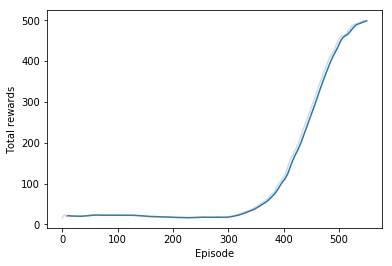

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

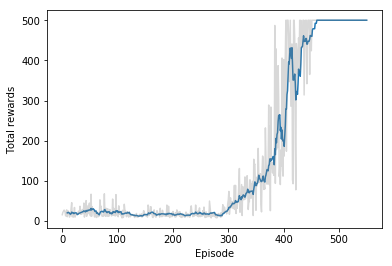

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

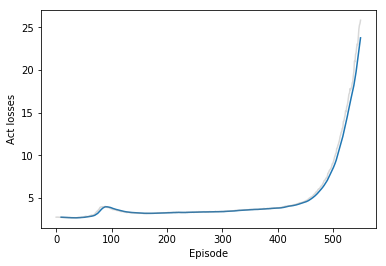

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

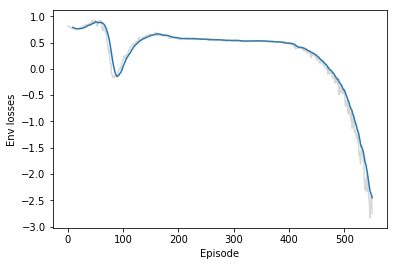

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
